In [50]:
import torch
import numpy as np

In [51]:
from torchtext.legacy import data
from torchtext.legacy import datasets

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [69]:
CUDA_LAUNCH_BLOCKING=1
import pandas as pd
# import spacy
import numpy as np
# nlp = spacy.load('en_core_web_sm')
test_df = pd.read_csv("bert_features_sentiment.csv", header=None)

X = test_df[0]
Y_true = test_df[1]
pred_res = []
sentences = [sentence for i, sentence in X.items()]
sentence_embeddings = model.encode(sentences)


In [ ]:
import numpy as np

label_new =[]
for i in range(len(Y_true)):
    # if tweet[i] is not np.nan:
    #     # print(tweet[i])
    if Y_true[i] == 1:
        label_new.append(0)
    elif Y_true[i] == 2:
        label_new.append(1)
    elif Y_true[i] == 3:
        label_new.append(2)
    elif Y_true[i] == 4:
        label_new.append(3)
    elif Y_true[i] == 5:
        label_new.append(4)

In [ ]:
label_new

In [ ]:
sentence_embeddings.shape

In [71]:
import keras
# from keras.utils import objectives
import numpy as np
from math import floor
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Layer
from keras.layers.core import Flatten, Dense, Dropout, Lambda
# from keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
# from keras import objectives
# import tensorflow.contrib.keras as keras
from tensorflow.python.framework.ops import disable_eager_execution



class VAE:
    def __init__(self, input_dim, latent_dim, hidden_dims, batch_size, optimizer='rmsprop', epsilon_std = .01):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.epsilon_std = epsilon_std
        self.build_model()

    def build_model(self):
        input_layer = Input(batch_shape=(self.batch_size, self.input_dim))
        self.build_encoder(input_layer)
        self.build_decoder()
        self.autoencoder = Model(input_layer, self.x_decoded_mean)
        vae_loss = self._get_vae_loss()
        self.autoencoder.compile(optimizer=self.optimizer, loss=vae_loss)

    def build_encoder(self, input_layer):
        prev_layer = input_layer
        for q in self.hidden_dims:
            hidden = Dense(q, activation='relu')(prev_layer)
            prev_layer = hidden
        self._build_z_layers(hidden)
        self.encoder = Model(input_layer, self.z_mean)

    def _build_z_layers(self, hidden_layer):
        self.z_mean = Dense(self.latent_dim)(hidden_layer)
        self.z_log_sigma = Dense(self.latent_dim)(hidden_layer)

    def build_decoder(self):
        z = self._get_sampling_layer()
        prev_layer = z
        for q in self.hidden_dims:
            hidden = Dense(q, activation='relu')(prev_layer)
            prev_layer = hidden
        self.x_decoded_mean = Dense(self.input_dim, activation='sigmoid')(prev_layer)

        # Build the stand-alone generator
        generator_input = Input((self.latent_dim,))
        prev_layer = generator_input
        for q in self.hidden_dims:
            hidden = Dense(q, activation='relu')(prev_layer)
            prev_layer = hidden
        gen_x_decoded_mean = Dense(self.input_dim, activation='sigmoid')(prev_layer)
        self.generator = Model(generator_input, gen_x_decoded_mean)

    def _get_sampling_layer(self):
        def sampling(args):
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(self.batch_size, self.latent_dim),
                                      mean=0., stddev=self.epsilon_std)
            return z_mean + z_log_sigma * epsilon
        return Lambda(sampling, output_shape=(self.latent_dim,))([self.z_mean, self.z_log_sigma])

    def _get_vae_loss(self):
        z_log_sigma = self.z_log_sigma
        z_mean = self.z_mean
        def vae_loss(x, x_decoded_mean):
            reconstruction_loss = tf.keras.metrics.mean_squared_error(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
            return reconstruction_loss + kl_loss

        return vae_loss


class VAE_LSTM(VAE):
    def __init__(self, input_dim, latent_dim, hidden_dims, timesteps, batch_size, optimizer='rmsprop', epsilon_std = .01):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.batch_size = batch_size
        self.timesteps = timesteps
        self.optimizer = optimizer
        self.epsilon_std = epsilon_std
        self.build_model()

    def build_model(self):
        input_layer = Input(shape=(self.timesteps, self.input_dim,))
        self.build_encoder(input_layer)
        self.build_decoder()
        self.autoencoder = Model(input_layer, self.x_decoded_mean)
        vae_loss = self._get_vae_loss()
        self.autoencoder.compile(optimizer=self.optimizer, loss=vae_loss)

    def build_encoder(self, input_layer):
        prev_layer = input_layer
        for q in self.hidden_dims:
            hidden = LSTM(q)(prev_layer)
            prev_layer = hidden
        self._build_z_layers(hidden)
        self.encoder = Model(input_layer, self.z_mean)

    def build_decoder(self):
        z = self._get_sampling_layer()
        prev_layer = RepeatVector(self.timesteps)(z)
        for q in self.hidden_dims:
            hidden = LSTM(q, return_sequences=True)(prev_layer)
            prev_layer = hidden
        self.x_decoded_mean = LSTM(self.input_dim, return_sequences=True)(prev_layer)

        # Build the stand-alone generator
        generator_input = Input((self.latent_dim,))
        prev_layer = RepeatVector(self.timesteps)(generator_input)
        for q in self.hidden_dims:
            hidden = LSTM(q, return_sequences=True)(prev_layer)
            prev_layer = hidden
        gen_x_decoded_mean = LSTM(self.input_dim, return_sequences=True)(prev_layer)
        self.generator = Model(generator_input, gen_x_decoded_mean)
  



In [ ]:
N = len(sentence_embeddings)
disable_eager_execution()
train = np.array(sentence_embeddings).astype(float)
train = train.reshape([N,1,768])

batch_size = 50
epochs = 300
input_dim = train.shape[-1]
timesteps = train.shape[1]

model = VAE_LSTM(input_dim=input_dim, latent_dim=100, hidden_dims=[32], timesteps=timesteps, batch_size=batch_size)
vae, encoder, generator = model.autoencoder, model.encoder, model.generator
#tf.compat.v1.disable_eager_execution()
vae.fit(train[:floor(N/batch_size)*batch_size],train[:floor(N/batch_size)*batch_size], shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(train[N-1-batch_size:N-1],train[N-1-batch_size:N-1]))

In [8]:
vector_vae = encoder.predict(np.array(train), batch_size = batch_size)

In [33]:
from imblearn.over_sampling import ADASYN 

ada = ADASYN(random_state=42)
vector_vae_balanced, label_new_balanced = ada.fit_resample(vector_vae, label_new)

In [34]:
import pandas as pd

pd.DataFrame(vector_vae_balanced).to_csv('vector_vae_balanced.csv', index=False)
pd.DataFrame(label_new_balanced).to_csv('label_new_balanced.csv', index=False)

In [4]:
from torch import nn
from torch.utils.data import Dataset
import numpy as np
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold


class Net(nn.Module):

    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.droprate = 0.95
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.Dropout(p=self.droprate), nn.BatchNorm1d(n_hidden_1), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.Dropout(p=self.droprate), nn.BatchNorm1d(n_hidden_2), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim), nn.Dropout(p=self.droprate))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


class CustomDataset(Dataset):
    def __init__(self):
        self.data = torch.from_numpy(pd.read_csv('vector_vae_balanced.csv').values).float()
        self.labels = torch.from_numpy(pd.read_csv('label_new_balanced.csv').values).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.data[idx,:]
        labels = self.labels[idx]
        return sample, labels


In [5]:
def process(X_train, X_test, y_train, y_test):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    Y_train = np.array(y_train)
    Y_test = np.array(y_test)
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    Y_train = torch.from_numpy(Y_train).squeeze().to(torch.int64)
    Y_test = torch.from_numpy(Y_test).squeeze().to(torch.int64)
    train_dataset = []
    test_dataset = []
    for i in range(len(X_train)):
        train_dataset.append((X_train[i],Y_train[i]))
    for i in range(len(X_test)):
        test_dataset.append((X_test[i],Y_test[i]))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

#do not standardize the one hot features
def process_sentiment(X_train, X_test, y_train, y_test):
    sentiment_train = X_train[:,len(X_train[0])-5:len(X_train[0])]
    sentiment_test = X_test[:,len(X_test[0])-5:len(X_test[0])]
    X_train = X_train[:,:len(X_train[0])-5]
    X_test = X_test[:,:len(X_test[0])-5]
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.hstack((X_train, sentiment_train))
    X_test = np.hstack((X_test, sentiment_test))
    Y_train = np.array(y_train)
    Y_test = np.array(y_test)
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    Y_train = torch.from_numpy(Y_train).squeeze().to(torch.int64)
    Y_test = torch.from_numpy(Y_test).squeeze().to(torch.int64)
    train_dataset = []
    test_dataset = []
    for i in range(len(X_train)):
        train_dataset.append((X_train[i],Y_train[i]))
    for i in range(len(X_test)):
        test_dataset.append((X_test[i],Y_test[i]))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def classifier(input_dim, train_loader, test_loader, totEpoch, num_class, len_test):
    model = Net(input_dim, 100, 30, 4)
    if torch.cuda.is_available():
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epoch = 0
    train_loss_list = []
    loss_list = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    F1_list = []
    F1_list_train = []
    TPR0_list=[]
    FPR0_list=[]
    y_pred_list=[]
    lable_list=[]

    for epoch2 in range(0, 0 + totEpoch):
      # model.eval()
        num_TP = [0]*num_class
        num_FP = [0]*num_class
        num_FN = [0]*num_class
        eval_loss = 0
        eval_acc = 0
        eval_TP = [0]*num_class
        eval_FP = [0]*num_class
        eval_FN = [0]*num_class
        precision = [0]*num_class
        recall = [0]*num_class
        F1 = [0]*num_class
        for data in train_loader:
            img, label = data
            if torch.cuda.is_available():
                img = img.cuda()
                label = label.cuda()
            else:
                img = Variable(img)
                label = Variable(label)
            out = model(img)
            loss = criterion(out, label)
            # print_loss = loss.data.item()
            _, pred = torch.max(out, 1)
            num_correct = (pred == label).sum()

            for i in range(num_class):
                num_TP[i] = (((pred == i) & (label == i))).sum()
                num_FP[i] = (((pred == i) & (label != i))).sum()
                num_FN[i] = (((pred != i) & (label == i))).sum()
                eval_TP[i] += num_TP[i].item()
                eval_FP[i] += num_FP[i].item()
                eval_FN[i] += num_FN[i].item()
            eval_acc += num_correct.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch+=1

        for i in range(num_class):
            if (eval_TP[i] + eval_FP[i]) == 0:
                precision[i] = 1
            else:
                precision[i] = eval_TP[i] / (eval_TP[i] + eval_FP[i])
            if (eval_TP[i] + eval_FN[i]) == 0:
                recall[i] = 1
            else:
                recall[i] = eval_TP[i] / (eval_TP[i] + eval_FN[i])
            if (precision[i]+recall[i]) == 0:
                F1[i] = 0
            else:
                F1[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
            print('Train F1: {:.6f}'.format(
          sum(F1)/num_class,
      ))
            F1_list_train.append(sum(F1)/num_class)

        model.eval()
        print('epoch: {}, loss: {:.4}'.format(epoch2, loss.data.item()))
        train_loss_list.append(loss.data.item())

      # model.eval()
        num_TP = [0]*num_class
        num_FP = [0]*num_class
        num_FN = [0]*num_class
        num_TN = [0]*num_class
        eval_loss = 0
        eval_acc = 0
        eval_TP = [0]*num_class
        eval_FP = [0]*num_class
        eval_FN = [0]*num_class
        eval_TN  = [0]*num_class
        precision = [0]*num_class
        recall = [0]*num_class
        F1 = [0]*num_class
        
        
        # here add roc
        FPR = [0]*num_class
        TPR = [0]*num_class
        y_pred = [0]*num_class
        
        
        
        for data in test_loader:
            img, label = data
          # img = img.view(img.size(0), -1)
            if torch.cuda.is_available():
                img = img.cuda()
                label = label.cuda()

            out = model(img)
            loss = criterion(out, label)
            eval_loss += loss.data.item()*label.size(0)
            _, pred = torch.max(out, 1)
            num_correct = (pred == label).sum()
            y_pred = pred.cpu().numpy()
            lable_pred = label.cpu().numpy()
            if epoch2 == totEpoch - 1:
                y_pred_list.append(y_pred)
                lable_list.append(lable_pred)
            for i in range(num_class):
                num_TP[i] = (((pred == i) & (label == i))).sum()
                num_FP[i] = (((pred == i) & (label != i))).sum()
                num_FN[i] = (((pred != i) & (label == i))).sum()
                num_TN[i] = (((pred != i) & (label != i))).sum()
                eval_TP[i] += num_TP[i].item()
                eval_FP[i] += num_FP[i].item()
                eval_FN[i] += num_FN[i].item()
                eval_TN[i] += num_TN[i].item()
            eval_acc += num_correct.item()
        for i in range(num_class):
            if (eval_TP[i] + eval_FP[i]) == 0:
                precision[i] = 1
            elif (eval_FP[i] + eval_TN[i]) == 0:
                FPR[i] = 0
            elif (eval_TP[i] + eval_FN[i]) == 0:
                TPR[i] = 0
            else:
                FPR[i] = eval_FP[i] / (eval_FP[i] + eval_TN[i])
                TPR[i] = eval_TP[i] / (eval_TP[i] + eval_FN[i])
                precision[i] = eval_TP[i] / (eval_TP[i] + eval_FP[i])
            if (eval_TP[i] + eval_FN[i]) == 0:
                recall[i] = 1
            else:
                recall[i] = eval_TP[i] / (eval_TP[i] + eval_FN[i])
            if (precision[i]+recall[i]) == 0:
                F1[i] = 0
            else:
                F1[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
        print('Test Loss: {:.6f}, Acc: {:.6f}, Pre: {:.6f}, Rec: {:.6f}, F1: {:.6f}'.format(
          eval_loss / (len_test),
          eval_acc / (len_test),
          sum(precision)/num_class,
          sum(recall)/num_class,
          sum(F1)/num_class
      ))
        loss_list.append(loss.data.item())
        accuracy_list.append(eval_acc / (len_test))
        precision_list.append(sum(precision)/num_class)
        recall_list.append(sum(recall)/num_class)
        F1_list.append(sum(F1)/num_class)
        TPR0_list.append(TPR[1])
        FPR0_list.append(FPR[1])
    return [np.array(accuracy_list), np.array(precision_list), np.array(recall_list), np.array(F1_list), np.array(F1_list_train), np.array(loss_list), np.array(train_loss_list)], TPR0_list, FPR0_list, y_pred_list, lable_list

def train_model(vector_vae, label, model, totEpoch, num_class, random_s):
    X_train, X_test, y_train, y_test = train_test_split(vector_vae, label, test_size=0.2, random_state = random_s)
    train_loader, test_loader = process_sentiment(X_train, X_test, y_train, y_test)
    results= classifier(model, train_loader, test_loader, totEpoch, num_class, len(y_test))
    return results

def train_cross_val(input_dim, vector_vae, label, totEpoch, num_class, k):
    results = [np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*3*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch)]
    kf = StratifiedKFold(n_splits=k)
    c = 0
    var_test, var_train = [], []
    F1_train, F1_test = [], []
    Loss_train, Loss_test = [], []
    for train_index, test_index in kf.split(vector_vae, label):
        print('The ', c, ' th fold cross validation:')
        X_train = vector_vae[train_index]
        y_train = label[train_index]
        X_test = vector_vae[test_index]
        y_test = label[test_index]
        train_loader, test_loader = process_sentiment(X_train, X_test, y_train, y_test)
        result_list, TPR, FPR, y_pred, lable_list= classifier(input_dim, train_loader, test_loader, totEpoch, num_class, len(y_test))
        var_test.append(result_list[3])
        var_train.append(result_list[4])
        # print((var_train))
        F1_train.append(result_list[4])
        # print((F1_train))
        F1_test.append(result_list[3])
        Loss_train.append(result_list[6])
        Loss_test.append(result_list[5])
        for i in range(7):
            # print(i)
            results[i] += result_list[i]
        c += 1
    for i in range(7):
        results[i] /= k
    var_test = np.array(var_test)
    var_train = np.array(var_train)
    results.append(np.var(var_train, axis = 0))
    results.append(np.var(var_test, axis = 0))
    return results, F1_train, F1_test, Loss_train, Loss_test, TPR, FPR, y_pred, lable_list

In [6]:
# CUDA_LAUNCH_BLOCKING=1
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, KFold


batch_size = 128
learning_rate = 0.002

vector_vae = torch.from_numpy(pd.read_csv('vector_vae_balanced.csv').values).float()
label = torch.from_numpy(pd.read_csv('label_new_balanced.csv').values).float()

totEpoch = 100
num_class = 3
results, F1_train, F1_test, Loss_train, Loss_test,TPR, FPR, y_pred, y_lable = train_cross_val(100, vector_vae, label, totEpoch, num_class, 5)

The  0  th fold cross validation:
Train F1: 0.000000
Train F1: 0.039371
Train F1: 0.050415
epoch: 0, loss: 1.549
Test Loss: 1.334253, Acc: 0.330208, Pre: 0.776736, Rec: 0.666667, F1: 0.498825
Train F1: 0.333333
Train F1: 0.436330
Train F1: 0.569575
epoch: 1, loss: 1.125
Test Loss: 1.123410, Acc: 0.350228, Pre: 0.543297, Rec: 0.473489, F1: 0.475443
Train F1: 0.333333
Train F1: 0.455379
Train F1: 0.620359
epoch: 2, loss: 1.076
Test Loss: 1.107346, Acc: 0.319311, Pre: 0.548793, Rec: 0.575127, F1: 0.545873
Train F1: 0.333333
Train F1: 0.533377
Train F1: 0.699266
epoch: 3, loss: 0.9154
Test Loss: 1.185470, Acc: 0.326153, Pre: 0.558259, Rec: 0.637028, F1: 0.545327
Train F1: 0.333333
Train F1: 0.547158
Train F1: 0.702579
epoch: 4, loss: 0.9247
Test Loss: 1.210475, Acc: 0.330208, Pre: 0.562679, Rec: 0.644242, F1: 0.544660
Train F1: 0.333333
Train F1: 0.550832
Train F1: 0.718968
epoch: 5, loss: 0.9891
Test Loss: 1.187416, Acc: 0.335530, Pre: 0.563960, Rec: 0.648791, F1: 0.549477
Train F1: 0.333

In [9]:
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def prec_rec_curve(y_lable, y_pred, titile=""):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    n_classes = 3
    y_test = label_binarize(y_lable, classes=[1,2,3])
    y_score = label_binarize(y_pred, classes=[1,2,3])
    print(y_test)
    print(y_score)
    print(y_lable)
    print(y_pred)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    try:
        micro_auc = roc_auc_score(y_test, y_score, average='micro')
    except ValueError:
        pass
    # micro_auc = roc_auc_score(y_test, y_score, average='micro')
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    try:
        macro_auc = roc_auc_score(y_test, y_score, average='macro')
    except ValueError:
        pass
    # macro_auc = roc_auc_score(y_test, y_score, average='macro')

    print(roc_auc)
    print('micro auc:', micro_auc)
    print('macro auc:', macro_auc)
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('figures/VAE_ROC.jpg')

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]
[[0 0 1]
 [0 1 0]
 [0 1 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]
[2 2 2 ... 3 3 3]
[3 2 2 ... 3 3 3]
{0: 0.9083504781189191, 1: 0.7693533902110462, 2: 0.8016249263235753, 'micro': 0.8262797769893564, 'macro': 0.8264429315511803}
micro auc: 0.8262797769893564
macro auc: 0.8264429315511803


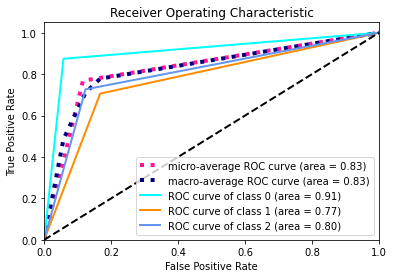

In [10]:
prec_rec_curve(np.concatenate( y_lable, axis=0 ), np.concatenate( y_pred, axis=0 ))

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
cm = confusion_matrix(np.concatenate( y_lable, axis=0 ), np.concatenate( y_pred, axis=0 ), normalize = 'true')
cm

array([[0.87423313, 0.09202454, 0.03374233],
       [0.08295626, 0.70588235, 0.21116139],
       [0.03191489, 0.24164134, 0.72644377]])

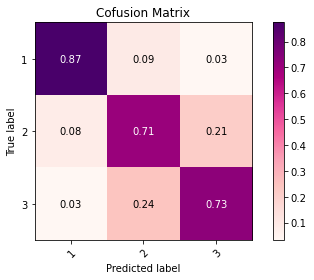

In [13]:
normalize = True
cmap = 'RdPu'
classes = [1,2,3]
title = 'Cofusion Matrix'
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes, ylabel = 'True label', xlabel = 'Predicted label', title = title)
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right', rotation_mode = 'anchor')
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha = 'center', va = 'center', color = 'white' if cm[i,j] > thresh else 'black')
        fig.tight_layout()
# plt.savefig('figures/VAE_CM.jpg')